# Random Forest Classification
### Import libraries

In [87]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, train_test_split, HalvingGridSearchCV)
from sklearn.experimental import enable_halving_search_cv  # neded for halving grid search per the docs
from sklearn.tree import export_graphviz
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report)

import graphviz

### Load and preprocess data

In [2]:
# I have already cleaned this dataset, converted values to numeric where needed, and created dummy variables
data_for_modeling = pd.read_csv('Cleaned_data.csv', index_col=0)

In [3]:
data_for_modeling

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9997,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9998,709,36,7,0.00,1,0,1,42085.58,1,0,0,0


In [4]:
data_for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  int64  
 10  Geography_Spain    10000 non-null  int64  
 11  Gender_Male        10000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1015.6 KB


### Visualize

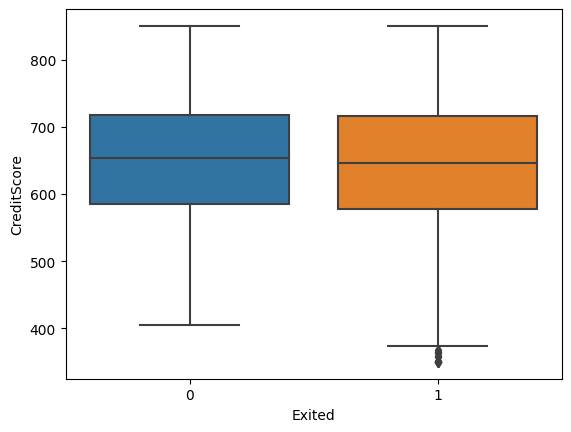

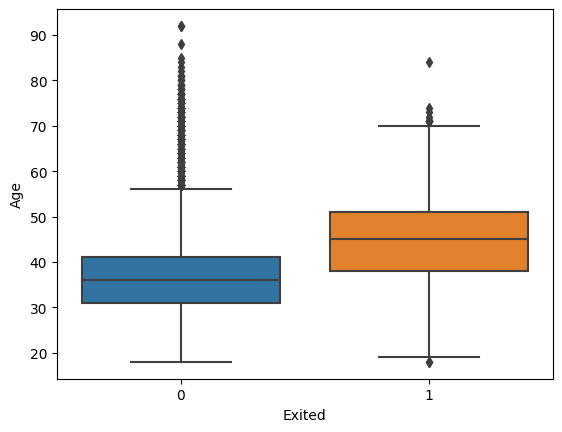

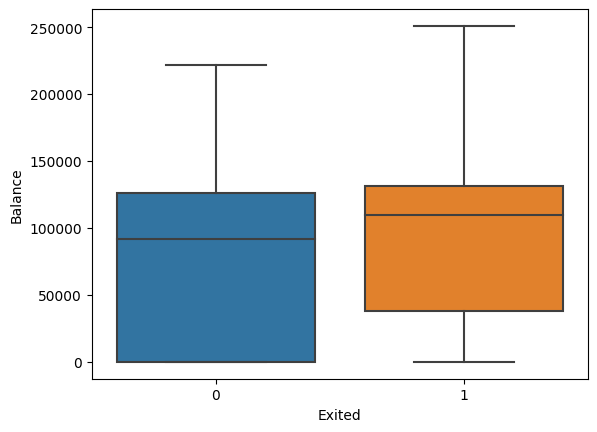

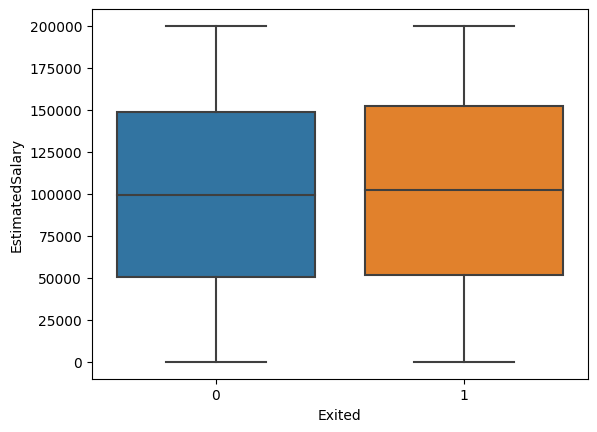

<Figure size 640x480 with 0 Axes>

In [5]:
cols_to_box = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for col in cols_to_box:
    sns.boxplot(data=data_for_modeling, y=col, x='Exited')
    plt.show()
    plt.clf()

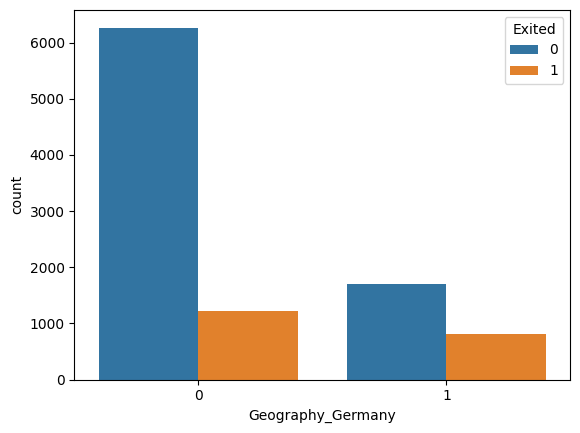

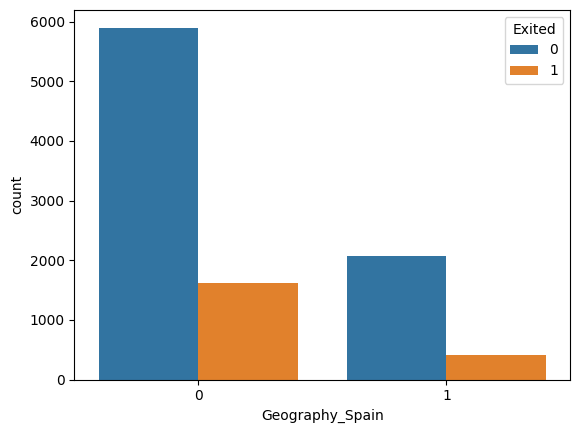

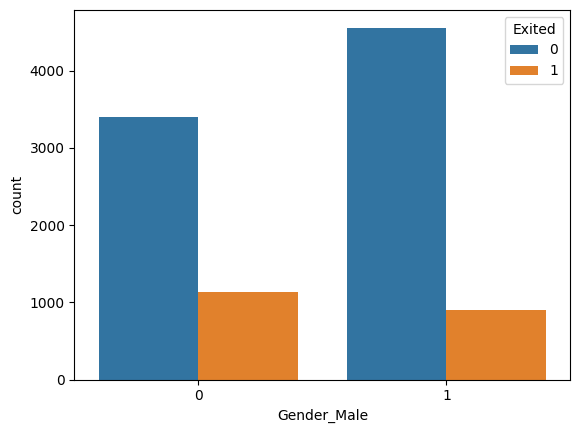

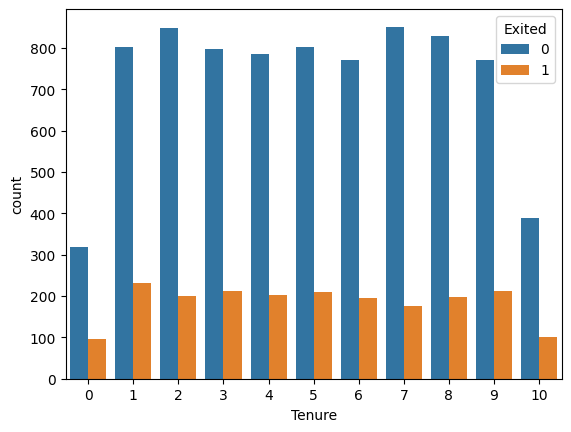

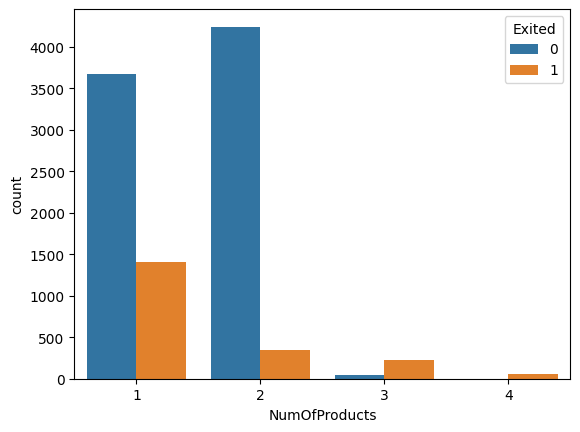

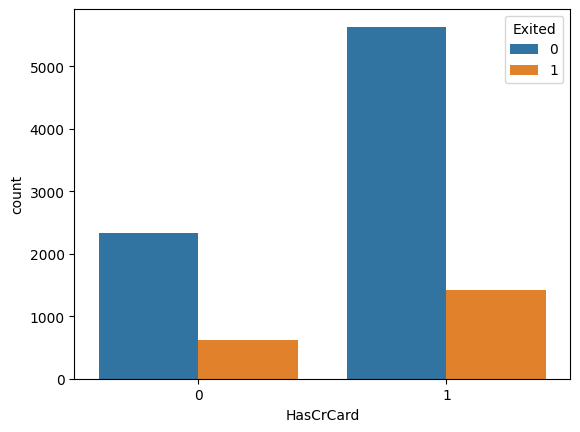

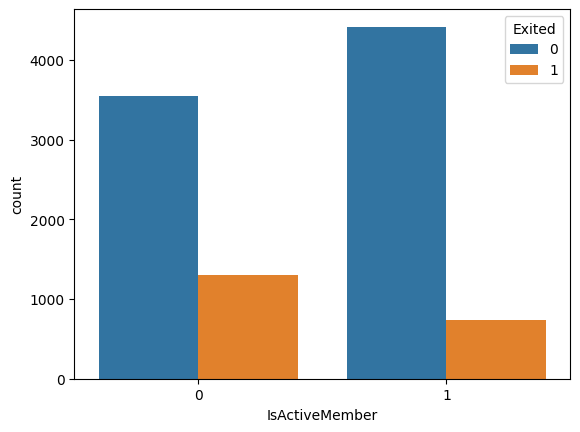

<Figure size 640x480 with 0 Axes>

In [6]:
bivariate_viz = ['Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

for col in bivariate_viz:
    sns.countplot(data=data_for_modeling, x=col, hue='Exited')
    plt.show()
    plt.clf()

### Train test split

In [37]:
X = data_for_modeling.drop(columns=['Exited'])
y = data_for_modeling['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
y_train.value_counts()

0    5547
1    1453
Name: Exited, dtype: int64

In [9]:
y_test.value_counts()

0    2416
1     584
Name: Exited, dtype: int64

### Create model

In [86]:
clf = RandomForestClassifier(max_depth=5, random_state=13, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=13)

### Evaluate

In [66]:
# stratified k-fold cross-validation is an effective evaluation metric when used on problems with imbalanced classes
# it ensures roughly the same percentage of target samples in each fold
# https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

def evaluate_model(model_name):
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=13)
    scores = cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=cross_val, n_jobs=-1, error_score='raise')
    print(f'Accuracy: {round(np.mean(scores), 3)} ({round(np.std(scores), 3)})')

    yhat = list(map(round, model_name.predict(X_test)))
    print(classification_report(y_test, yhat))

In [67]:
def plot_confusion_matrix(model_name):
    # get class predictions
    yhat = list(map(round, model_name.predict(X_test)))

    # confusion matrix
    cm = confusion_matrix(y_test, yhat, normalize='true') 
    print ("Confusion Matrix : \n", cm) 
    
    # accuracy score of the model
    print('Test accuracy = ', accuracy_score(y_test, yhat))

    sns.heatmap(cm, cmap='YlGnBu', annot=True)
    plt.title('Confusion Matrix')
    plt.show()
    plt.clf()

In [84]:
evaluate_model(clf)

Accuracy: 0.803 (0.026)
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2416
           1       0.48      0.75      0.59       584

    accuracy                           0.79      3000
   macro avg       0.71      0.78      0.72      3000
weighted avg       0.84      0.79      0.81      3000



Confusion Matrix : 
 [[0.80339404 0.19660596]
 [0.24828767 0.75171233]]
Test accuracy =  0.7933333333333333


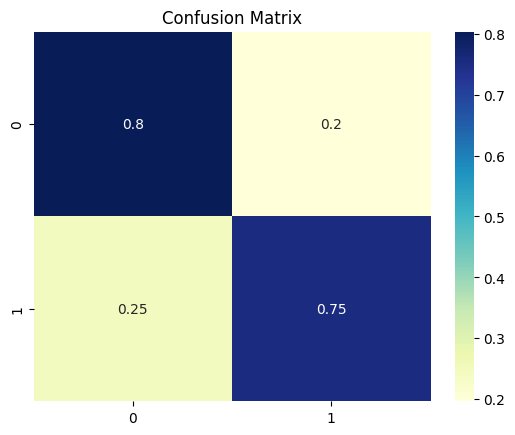

<Figure size 640x480 with 0 Axes>

In [85]:
plot_confusion_matrix(clf)

### Tune Hyperparameters

In [70]:
# view model parameters
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

In [71]:
# Number of trees in random forest
n_estimators = [50, 100, 200, 400]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# halving cross validation performs more quickly than grid search
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-heatmap-py
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=13
)
gsh.fit(X_train, y_train)

HalvingGridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     random_state=13),
                    factor=2,
                    param_grid={'min_samples_leaf': [1, 2, 4],
                                'min_samples_split': [2, 5, 10],
                                'n_estimators': [50, 100, 200, 400]},
                    random_state=13)

In [72]:
params = gsh.best_params_
params

{'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}

In [73]:
gsh.best_score_

0.7924014336917563

### Try optimized model

In [74]:
# creating a model using the best parameters identified by grid search 
clf_optimized = RandomForestClassifier(max_depth=5, random_state=13, class_weight='balanced',
                                       min_samples_leaf=params['min_samples_leaf'], 
                                       min_samples_split=params['min_samples_split'], 
                                       n_estimators=params['n_estimators'])
clf_optimized.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=400, random_state=13)

In [75]:
evaluate_model(clf_optimized)

Accuracy: 0.804 (0.025)
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      2416
           1       0.48      0.74      0.58       584

    accuracy                           0.79      3000
   macro avg       0.71      0.77      0.72      3000
weighted avg       0.84      0.79      0.81      3000



Confusion Matrix : 
 [[0.8067053  0.1932947 ]
 [0.25684932 0.74315068]]
Test accuracy =  0.7943333333333333


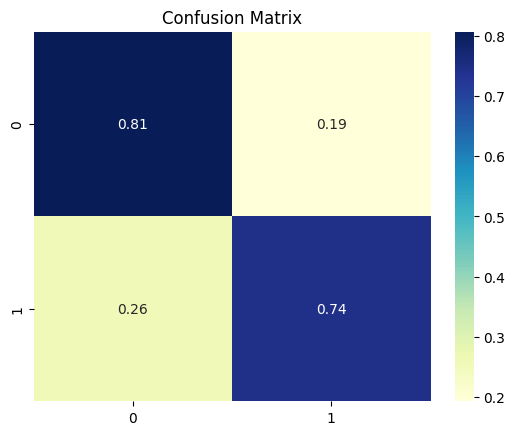

<Figure size 640x480 with 0 Axes>

In [76]:
plot_confusion_matrix(clf_optimized)

### Visualize individual trees

In [77]:
feature_names = X.columns

In [78]:
# estimators_ contains the individual trees, specifying the first tree here
tree = export_graphviz(clf_optimized.estimators_[0],
                    feature_names=feature_names,
                    filled=True,
                    impurity=True,
                    rounded=True,
                    precision=2)

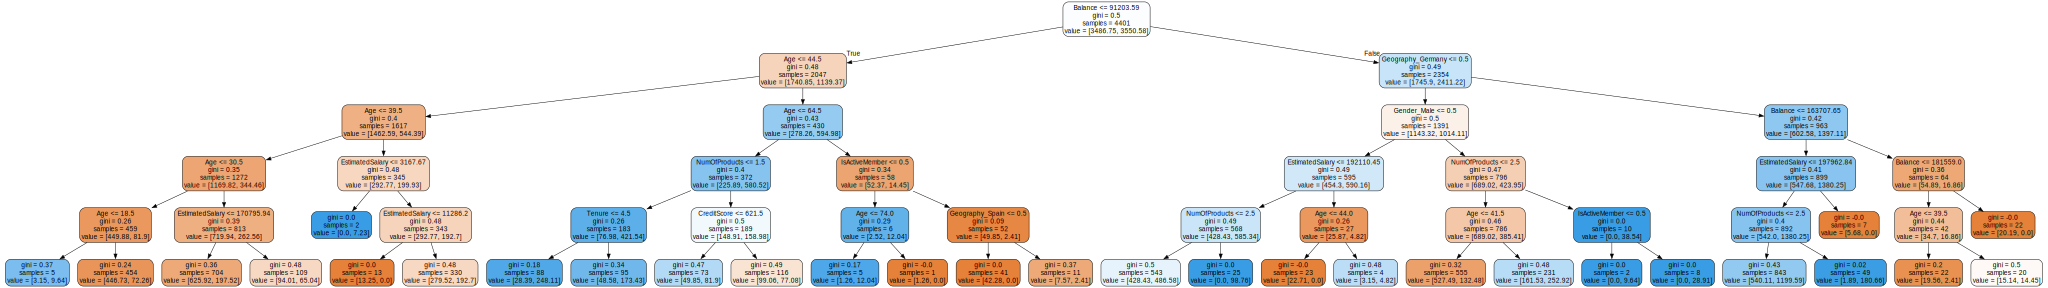

In [79]:
# format specifies a png object
graph = graphviz.Source(tree, format='png')
graph

In [81]:
# save image file
graph.render('Decision_tree_example')

'Decision_tree_example.png'